# Stress Testing Common XAI Algos in the Literature

In [1]:
import pandas as pd
import numpy as np
import lime
import os
import numpy as np

from classifiers.ClassifierWrapper import ClassifierWrapper
from classifiers.XGBoost import XGBoost
from classifiers.BNetClassifier import BayesNet
from classifiers.NeuralNet import NeuralNetwork

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

sns.set()

C:\Users\cmore\AppData\Local\Temp\ipykernel_5928\866261839.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Case #1: Data Generated from a Common Cause Structure with Independent Vars

The purpose of this test is to understand how current algorithms of the literature such as LIME and SHAP can represent feature in important in situations where data is generated from a common cause structure. We also added an independent variable to understand if this variable will be considered as relevant to the algorithm. We will train an XGboost classifier with data generated from the model below and run XAI algortihms to understand the computed feature importance.

<img src="https://raw.githubusercontent.com/catarina-moreira/XAI_Algos/0de91f13187c7a136676e049804c6b6e4de3ff44/networks/common_cause.png" />

In [2]:
# load the common cause data
data_common_cause = pd.read_csv(os.path.join("gen_data", "common_cause_v3.dat"))
data_common_cause.head()

,X1,X2,Y
0,0.162166,0,0
1,0.724821,1,0
2,0.784591,1,1
3,0.216756,0,0
4,0.828123,0,1


In [4]:
import tensorflow as tf

In [7]:
another_strategy = tf.distribute.MirroredStrategy()
# Loading the model using the lower-level API
with another_strategy.scope():
  loaded = tf.saved_model.load(os.path.join(".","models", "NN_common_cause_v3.json"))

loaded

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


'2.9.1'

In [3]:
clf_NNet = NeuralNetwork(True, "common_cause_v3", data_common_cause, "Y")
#clf_NNet.classify(save_model=True)


FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://46e1eb96-7e3b-414a-b860-d160278c3587/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

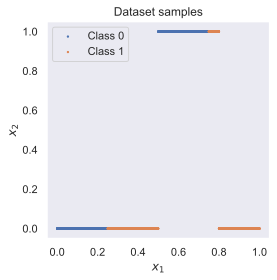

In [19]:

data_0 = clf_NNet.dataset[clf_NNet.dataset[clf_NNet.class_var] == 0].values
data_1 = clf_NNet.dataset[clf_NNet.dataset[clf_NNet.class_var] == 1].values

plt.figure(figsize=(4, 4))
plt.scatter(data_0[:, 0], data_0[:, 1], label="Class 0", s=2)
plt.scatter(data_1[:, 0], data_1[:, 1], label="Class 1", s=2)
plt.title("Dataset samples")
plt.ylabel(r"$x_2$")
plt.xlabel(r"$x_1$")
plt.legend()
plt.grid(False)

In [8]:
clf_NNet.plot_decision_boundary()

KeyError: False

In [6]:
clf_BNet = BayesNet(False, "common_cause_v3", data_common_cause,"Y")
clf_BNet.classify(save_model=False, learningMethod="GHC")

Overall Performace: 
	Classifier: Bayesian Network
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	ROC AUC Score: 1.0


BNClassifier(discretizationNbBins=4, discretizationStrategy='uniform',
             prior='Smoothing')

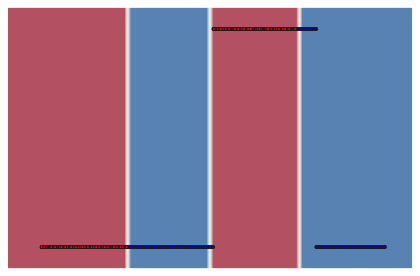

In [7]:
clf_BNet.plot_decision_boundary()

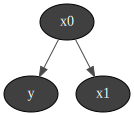

In [8]:
clf_BNet.show_bn()

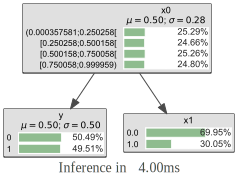

In [9]:
clf_BNet.show_query_mode()

In [10]:
clf_xgboost = XGBoost(True, "common_cause_v3", data_common_cause,"Y")
clf_xgboost

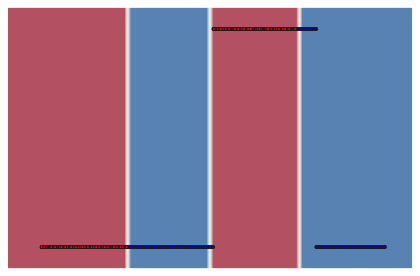

In [11]:
clf_xgboost.plot_decision_boundary()

### Generating Explanations for XGBoost

In [ ]:
from  lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer

In [ ]:
indx = 5

res = xgb.predict_proba([X_test[indx]])
print( "Prediction: " + str(np.argmax(res[0])) )

exp = explainer.explain_instance(X_test[indx], xgb.predict_proba, num_features=3)
fig = exp.as_pyplot_figure()

### Generating Explanations for Neural Net


In [ ]:
from  lime.lime_tabular import LimeTabularExplainer
explainer_nn = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer_nn

In [ ]:
predict_fn = lambda x:  1.0 if nn.predict(x) >= 0.5 else 0.0

In [ ]:
indx = 5

instance1 =  np.expand_dims(X_test[indx], axis=0) 
instance2 =  X_test[indx]

exp = explainer.explain_instance(X_test[indx], nn.predict, num_features=3)
fig = exp.as_pyplot_figure()

In [ ]:
explainer_bn = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer_bn